In [1]:
from segmentation_network import build_segmenter, preproc_dataset
from train_utils import load_dataset, dataset_loc
import theano.tensor as T
from theano import function as tfn
import cPickle as pickle
import numpy as np
import time
import lasagne.layers as ll
from os.path import join

Couldn't import dot_parser, loading of dot files will not be possible.

+------

<!!! WARNING !!!>
[!custom_layers] WARNING: GPU seems unavailable
<type 'exceptions.ImportError'>: No module named pylearn2.sandbox.cuda_convnet.filter_acts
</!!! WARNING !!!>

L______



Using gpu device 0: GeForce GTX 660 (CNMeM is disabled)


In [2]:
with open(join(dataset_loc, "Flukes/patches/annot_path_32/model.pkl"), 'r') as f:
    model = pickle.load(f)

test_dset = load_dataset(join(dataset_loc, "Flukes/patches/TESTannot_path_32"))


Loading /home/zach/data/Flukes/patches/TESTannot_path_32
Took 1.06 seconds


In [3]:
segmenter = build_segmenter()
ll.set_all_param_values(segmenter, model)

In [4]:
X = T.tensor4()
segmenter_out = ll.get_output(segmenter, X)
segmenter_fn = tfn([X], segmenter_out)

In [5]:
dset_for_model = {section:preproc_dataset(test_dset[section]) for section in test_dset}

In [6]:
#test_dset['train'][0]

In [7]:
segmentation_outputs = segmenter_fn(dset_for_model['train']['X'])

In [8]:
segmentation_outputs_valid = segmenter_fn(dset_for_model['valid']['X'])

In [9]:
np.sum(segmentation_outputs[0], axis=0)

array([[ 0.99999988,  0.99999988,  0.99999988, ...,  0.99999988,
         0.99999988,  0.99999988],
       [ 0.99999994,  0.99999994,  0.99999988, ...,  0.99999988,
         0.99999994,  0.99999982],
       [ 0.99999988,  0.99999988,  0.99999988, ...,  0.99999988,
         0.99999994,  0.99999988],
       ..., 
       [ 0.99999988,  0.99999994,  0.99999988, ...,  0.99999988,
         0.99999988,  0.99999988],
       [ 0.99999994,  0.99999982,  0.99999988, ...,  0.99999988,
         0.99999994,  0.99999988],
       [ 0.99999988,  0.99999994,  0.99999994, ...,  0.99999988,
         0.99999994,  0.99999988]], dtype=float32)

[[2 2 2 ..., 2 2 2]
 [2 2 2 ..., 2 2 2]
 [2 2 2 ..., 2 2 2]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


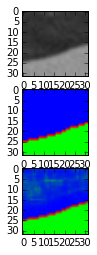

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_output(originals, true_labels, outputs, ind):
    original = (originals[ind].swapaxes(0,2)) * 255 + 128
    #original = originals[ind]
    true_label = true_labels[ind].swapaxes(0,2)
    output = outputs[ind].swapaxes(0,2)#.reshape(outputs.shape[3], outputs.shape[2], outputs.shape[1])
    print(np.argmax(output, axis=2))
    #print(output)
    f, ax = plt.subplots(3)
    ax[0].imshow(original)
    ax[1].imshow(true_label)
    ax[2].imshow(output)

show_output(dset_for_model['valid']['X'], dset_for_model['valid']['y'], segmentation_outputs_valid, 
            np.random.randint(segmentation_outputs_valid.shape[0]))

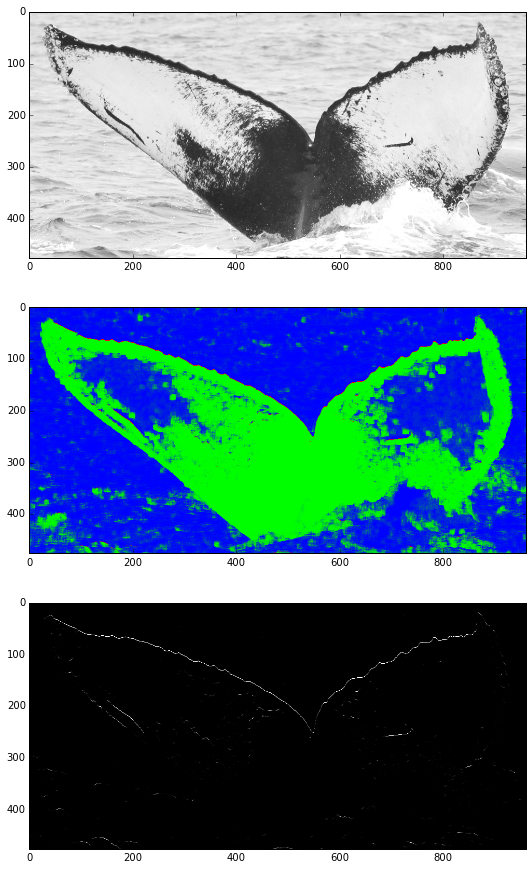

In [23]:
import glob
import random
import cv2
imgs_dir = join(dataset_loc, "Flukes/CRC_combined constrained/")
all_imgs = glob.glob(join(imgs_dir, "*"))
def see_random_image(all_imgs, network_fn):
    imgn = random.choice(all_imgs)
    img = cv2.imread(imgn)
    img_normed = np.array((img - 128) / 255., dtype='float32').swapaxes(0,2)
    img_normed = img_normed.reshape(1, *img_normed.shape)
    img_output = network_fn(img_normed)
    img_output = img_output.swapaxes(1,3)[0]
    f, ax = plt.subplots(3, figsize=(15,15))
    ax[0].imshow(img)
    #plt.gray()
    ax[1].imshow(img_output)
    plt.gray()
    ax[2].imshow(img_output[:,:,0])
see_random_image(all_imgs, segmenter_fn)

In [25]:
rand_imgfn = random.choice(all_imgs)
rand_img = cv2.imread(rand_imgfn)
img_normed = np.array((rand_img - 128) / 255., dtype='float32').swapaxes(0,2)
img_normed = img_normed.reshape(1, *img_normed.shape)

In [29]:
%timeit img_output = segmenter_fn(img_normed)
#img_output = img_output.swapaxes(1,3)[0]

1 loops, best of 3: 290 ms per loop
